# Welcome to the NoisePy Colab Tutorial

This tutorial will demonstrate how to use NoisePy to compute cross correlations and perform measurements of changes in seismic velocities


First, we install the noisepy-seis package

In [ ]:
#! pip install noisepy-seis --upgrade
# !pip uninstall noisepy-seis
# !conda install -n noisepy ipykernel --update-deps --force-reinstall
# !cd ..
# !pip install -e ".[dev]"
# !cd Jupyter_notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.5/753.5 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 14.4 MB/s eta

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

Then we import the basic modules

In [ ]:
from noisepy.seis import download, cross_correlate, stack, plotting_modules
from noisepy.seis.asdfstore import ASDFRawDataStore, ASDFCCStore
from noisepy.seis.datatypes import ConfigParameters
from dateutil.parser import isoparse
from noisepy.seis import noise_module
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from obspy.signal.filter import bandpass


logger = logging.getLogger(__name__)
path = "/content/data" # for use in Colab
# path = os.path.expanduser("~/data") # for local runs
# print(path)

MAX_MEM = 4.0

os.makedirs(path,exist_ok=True)

raw_data_path = os.path.join(path, "RAW_DATA")
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")
os.system(f"rm -rf {raw_data_path}")
os.system(f"rm -rf {cc_data_path}")

/usr/local/lib/python3.10/dist-packages/noisepy/seis/noise_module.py:1264: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit("float32[:](float32[:],float32)")


0

## Ambient Noise Project Configuration

We store the metadata information about the ambient noise cross correlation workflow in a ConfigParameters() object. We first initialize it, then we tune the parameters for this cross correlation.

In [ ]:
config = ConfigParameters() # default config parameters which can be customized
config.inc_hours = 12
config.start_date =  isoparse("2015-04-23")
config.end_date = isoparse("2015-04-24")
config.samp_freq= 40  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600.0  # (float) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = False  # only perform auto-correlation or not
config.xcorr_only = True  # only perform cross-correlation or not


config.lamin = 45       # min latitude
config.lamax = 46       # max latitude
config.lomin = -131    # min longitude
config.lomax = -129     # max longitude
config.net_list = ["OO"] # look for all network codes
config.stations = ["AXAS2","AXAS1"]
config.channels = ['EHZ']


 # pre-processing parameters
config.step= 1800.0  # (float) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.05
config.freqmax = 10.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= "rma"  # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = "no"  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= "xcorr"  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 200  # lags of cross-correlation to save (sec)
config.substack = True

In [ ]:
raw_data_path

'/content/data/RAW_DATA'

In [ ]:
config

ConfigParameters(start_date=datetime.datetime(2015, 4, 23, 0, 0), end_date=datetime.datetime(2015, 4, 24, 0, 0), samp_freq=40, cc_len=3600.0, lamin=45, lamax=46, lomin=-131, lomax=-129, step=1800.0, freqmin=0.05, freqmax=10.0, freq_norm='rma', time_norm='no', cc_method='xcorr', smooth_N=10, smoothspect_N=10, substack=True, substack_len=3600.0, maxlag=200, inc_hours=12, max_over_std=10, ncomp=3, stationxml=False, rm_resp='inv', rm_resp_out='VEL', respdir=None, acorr_only=False, xcorr_only=True, stack_method='linear', keep_substack=False, rotation=True, correction=False, down_list=False, net_list=['OO'], stations=['AXAS2', 'AXAS1'], channels=['EHZ'])

## Step 0: download data


This step will download data using obspy and save them into ASDF files locally. The data will be stored for each time chunk defined in hours by inc_hours.

The download will clean up the raw data by detrending, removing the mean, bandpassing (broadly), removing the instrumental response, merging gaps, ignoring too-gappy data.

Use the function ```download``` with the following arguments: 
* ```path``` of where to put the data
* ``` config```: Configuration Object.
* ```client_url_key```: the string for FDSN clients

Some raw parameters are still hardcoded in the download function that calles S0A_download_ASDF_MPI.py
I broadened the lat-long search, this could be a parameter in the config.


In [ ]:
# Download data locally. Enters raw data path, channel types, stations, config, and fdsn server.
download(raw_data_path, config, "IRIS")

List the files that were downloaded, just to make sure !

In [ ]:
print(os.listdir(raw_data_path))

['2015_04_23_00_00_00T2015_04_23_12_00_00.h5', '2015_04_23_12_00_00T2015_04_24_00_00_00.h5', 'station.txt']


Plot the raw data, make sure it's noise!

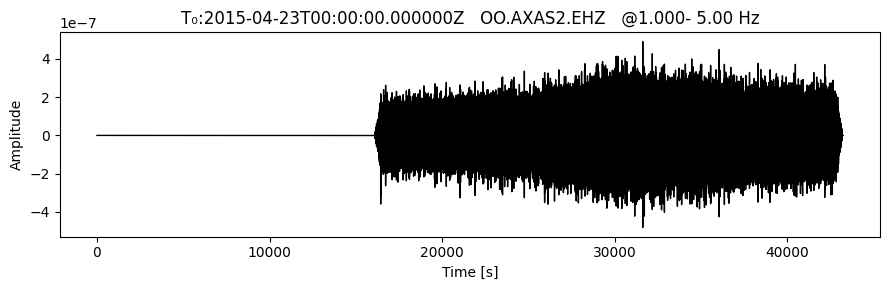

In [ ]:
file = os.path.join(raw_data_path, "2015_04_23_00_00_00T2015_04_23_12_00_00.h5")
plotting_modules.plot_waveform(file,'OO','AXAS2',1,5) # this function takes for input: filename, network, station, freqmin, freqmax for a bandpass filter

## Step 1: Cross-correlation

This step will perform the cross correlation. For each time chunk, it will read the data, perform classic ambient noise pre-processing (time and frequency normalization), FFT, cross correlation, substacking, saving cross correlations in to a temp ASDF file (this is not fast and will be improved).


In [ ]:
# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")

0

In [ ]:
config.freq_norm = "rma"
raw_store = ASDFRawDataStore(raw_data_path) # Store for reading raw data
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

# print the configuration parameters. Some are chosen by default but we cab modify them
print(config)

start_date=datetime.datetime(2015, 4, 23, 0, 0) end_date=datetime.datetime(2015, 4, 24, 0, 0) samp_freq=40 cc_len=3600.0 lamin=45 lamax=46 lomin=-131 lomax=-129 step=1800.0 freqmin=0.05 freqmax=10.0 freq_norm='rma' time_norm='no' cc_method='xcorr' smooth_N=10 smoothspect_N=10 substack=True substack_len=3600.0 maxlag=200 inc_hours=12 max_over_std=10 ncomp=3 stationxml=False rm_resp='inv' rm_resp_out='VEL' respdir='/content/data/RAW_DATA/../resp' acorr_only=False xcorr_only=True stack_method='linear' keep_substack=False rotation=True correction=False down_list=False net_list=['OO'] stations=['AXAS2', 'AXAS1'] channels=['EHZ']


In [ ]:
config.freq_norm = "rma"

Perform the cross correlation

In [ ]:
cross_correlate(raw_store, config, cc_store)

2023-06-08 02:25:42,884	INFO worker.py:1625 -- Started a local Ray instance.
(pid=24637) /usr/local/lib/python3.10/dist-packages/noisepy/seis/noise_module.py:1264: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
(pid=24637)   @jit("float32[:](float32[:],float32)")
(read_data_ray pid=24637) 2023-06-08 02:25:49,705 INFO asdfstore _get_dataset_cached ASDFCCStore - Opening /content/data/RAW_DATA/2015_04_23_00_00_00T2015_04_23_12_00_00.h5
(preprocess_ray pid=24637) 2023-06-08 02:25:50,649 INFO noise_module preprocess_raw removing response for OO.AXAS2..EHZ | 2015-04-23T00:00:00.000000Z - 2015-04-23T12:00:00.000000Z | 40.0 Hz, 1728001 samples using inv
(pid=24638) 2023-06-08 02:26:31

Plot a single set of the cross correlation

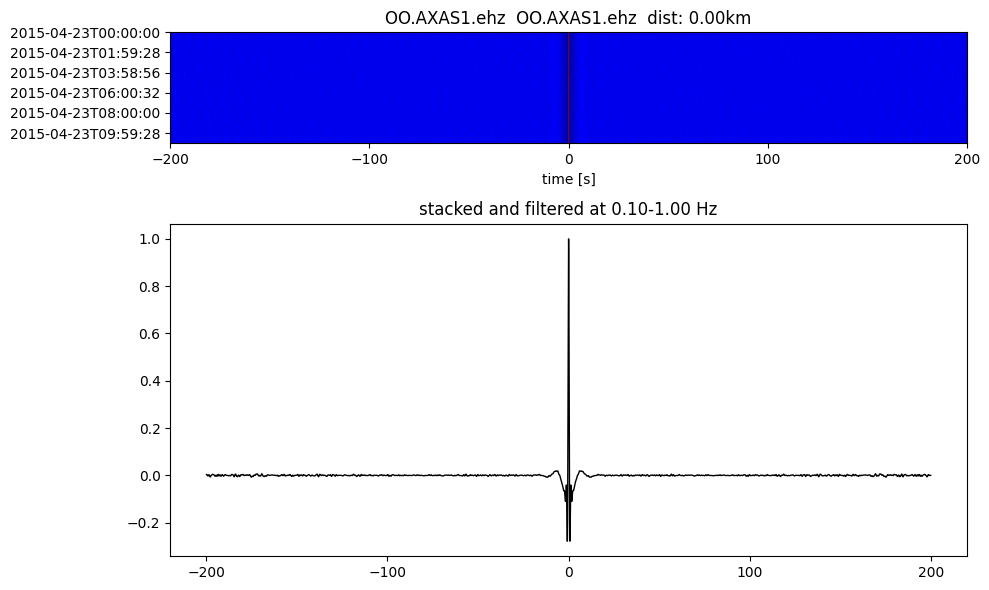

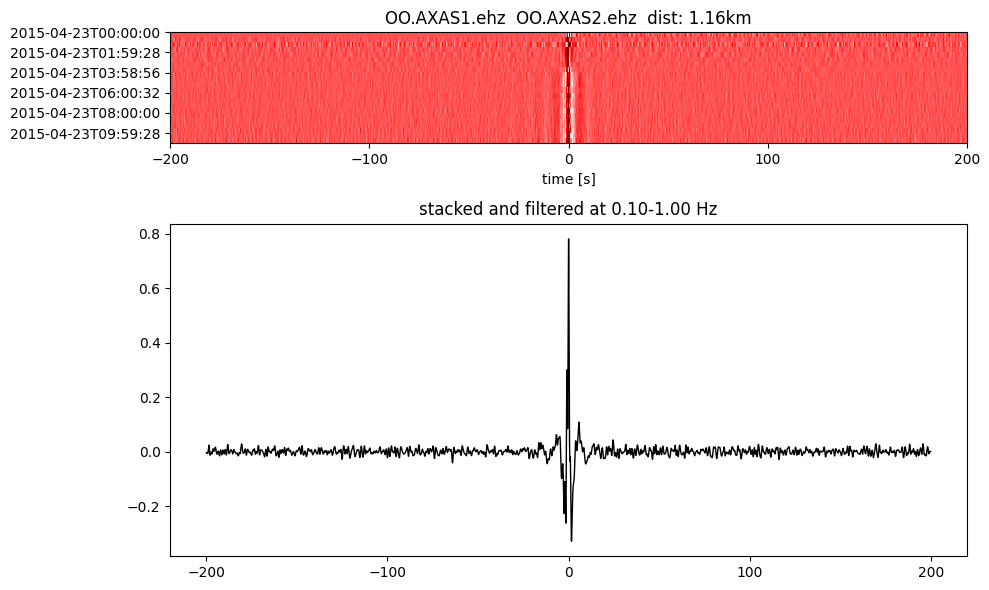

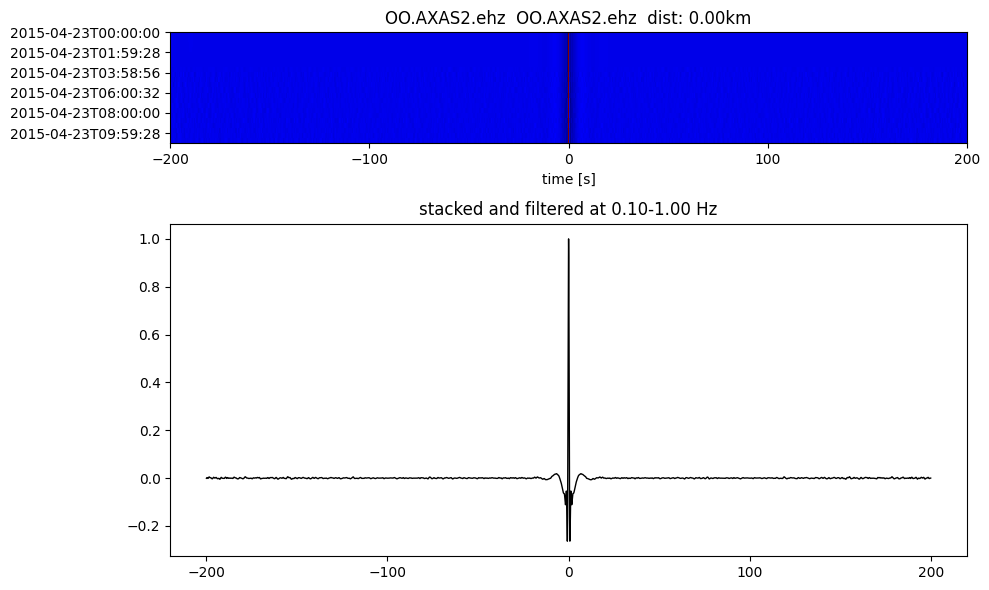

In [ ]:
file = os.path.join(cc_data_path, '2015_04_23_00_00_00T2015_04_23_12_00_00.h5')
plotting_modules.plot_substack_cc(file,0.1,1,200,False)

## Step 2: Look at invidual traces and make dv/v measurements


Some parameters

In [ ]:

# targeted component
stack_method = "linear"  # which stacked data to measure dispersion info
ccomp = "EN"  # cross component

# pre-defined group velocity to window direct and code waves
vmin = 0.8  # minimum velocity of the direct waves -> start of the coda window
lwin = 150  # window length in sec for the coda waves

# basic parameters
freq = [1, 2., 3., 5.]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1
onelag = False  # make measurement one one lag or two
norm_flag = True  # whether to normalize the cross-correlation waveforms
do_stretch = True  # use strecthing method or not
do_dtw = False  # use dynamic time warping method or not
do_mwcs = True  # use moving-window cross spectrum method or not
do_mwcc = False  # use moving-window cross correlation method or not
do_wts = True  # use wavelet streching method or not
do_wxs = True  # use wavelet cross spectrum method or not

# parameters for stretching method
epsilon = 2 / 100  # limit for dv/v (in decimal)
nbtrial = 50  # number of increment of dt [-epsilon,epsilon] for the streching

# parameters for DTW
mlag = 50  # maxmum points to move (times dt gives the maximum time shifts)
b = 5  # strain limit (to be tested)
direct = 1  # direction to accumulate errors (1=forward, -1=backward)

# parameters for MWCS & MWCC
move_win_sec = 1.2 * int(1 / np.min(freq))  # moving window length (in sec)
step_sec = 0.3 * move_win_sec  # step for moving window sliding (in sec)

# parameters for wavelet domain methods
dj = 1 / 12  # Spacing between discrete scales. Default value is 1/12.
s0 = -1  # Smallest scale of the wavelet. Default value is 2*dt.
J = -1  # Number of scales less one.
wvn = "morlet"  # wavelet class



Find all of the H5 files with the cross correlation in the cc_store

In [ ]:
timespans=cc_store.get_timespans()
pairs_all = list(set(pair for ts in timespans for pair in cc_store.get_station_pairs(ts)))
stations = set(pair[0] for pair in pairs_all)
print(timespans)
print(pairs_all)
print(stations)

[2015-04-23T00:00:00+0000 - 2015-04-23T12:00:00+0000, 2015-04-23T12:00:00+0000 - 2015-04-24T00:00:00+0000]
[(OO.AXAS2, OO.AXAS2), (OO.AXAS1, OO.AXAS2), (OO.AXAS1, OO.AXAS1)]
{OO.AXAS2, OO.AXAS1}


In [ ]:
sta_pair = pairs_all[0]
src_sta = sta_pair[0]
rec_sta = sta_pair[0]
print(src_sta,rec_sta)

OO.AXAS2 OO.AXAS2


Add on functions to calculate the number of segments

In [ ]:
from typing import Tuple
import logging
def calc_segments(fft_params: ConfigParameters, num_chunk: int) -> Tuple[int, int]:
    if fft_params.substack:  # things are difference when do substack
        if fft_params.substack_len == fft_params.cc_len:
            num_segmts = int(np.floor((fft_params.inc_hours * 3600 - fft_params.cc_len) / fft_params.step))
        else:
            num_segmts = int(fft_params.inc_hours / (fft_params.substack_len / 3600))
    npts_segmt = int(2 * fft_params.maxlag * fft_params.samp_freq) + 1
    memory_size = num_chunk * num_segmts * npts_segmt * 4 / 1024**3

    if memory_size > MAX_MEM:
        raise ValueError(
            "Require %5.3fG memory but only %5.3fG provided)! Cannot load cc data all once!" % (memory_size, MAX_MEM)
        )
    logger.debug("Good on memory (need %5.2f G and %s G provided)!" % (memory_size, MAX_MEM))
    return num_segmts, npts_segmt

In [ ]:
# calculate the number of segments
num_segmts, npts_segmt = calc_segments(config, len(timespans)*config.ncomp**2)
num_chunk = len(timespans) 
print(f"there are ",num_segmts," segments/windows and ",npts_segmt," points in each segments and overall",num_chunk," number of time chunks")

there are  22  segments/windows and  16001  points in each segments and overall 2  number of time chunks


In [ ]:
nccomp=config.ncomp**2
cc_array = np.zeros((nccomp*num_chunk * num_segmts, npts_segmt), dtype=np.float32)
cc_time = np.zeros(nccomp*num_chunk * num_segmts, dtype=np.float32)
cc_ngood = np.zeros(nccomp*num_chunk * num_segmts, dtype=np.int16)
cc_comp = np.chararray(nccomp*num_chunk * num_segmts, itemsize=2, unicode=True)
print(cc_array.shape)

(396, 16001)


In [ ]:
iseg = 0
for ts in timespans:
  # load the data from daily compilation
  ch_pairs = cc_store.get_channeltype_pairs(ts, src_sta, rec_sta)
  print(ch_pairs)
  logger.debug(f"path_list for {src_sta}-{rec_sta}: {ch_pairs}")

  # load the 9-component data, which is in order in the ASDF
  for ch_pair in ch_pairs:
      src_chan, rec_chan = ch_pair
      tcmp1 = src_chan.get_orientation()
      tcmp2 = rec_chan.get_orientation()

      # read data and parameter matrix
      tparameters, tdata = cc_store.read(ts, src_sta, rec_sta, src_chan, rec_chan)
      ttime = tparameters["time"]
      tgood = tparameters["ngood"]
      if config.substack:
          for ii in range(tdata.shape[0]):
              cc_array[iseg] = tdata[ii]
              cc_time[iseg] = ttime[ii]
              cc_ngood[iseg] = tgood[ii]
              cc_comp[iseg] = tcmp1 + tcmp2
              iseg += 1
      else:
          cc_array[iseg] = tdata
          cc_time[iseg] = ttime
          cc_ngood[iseg] = tgood
          cc_comp[iseg] = tcmp1 + tcmp2
          iseg += 1
print(iseg)

[(ehz, ehz)]
[(ehz, ehz)]
44


In [ ]:
print(cc_array.shape)


(396, 16001)


Once the data is stored in memory, we follow these steps:
* bandpass the data in a given frequency band, 
* stack to get a reference, 
* measure dv/v, save it into a pandas daataframe

9


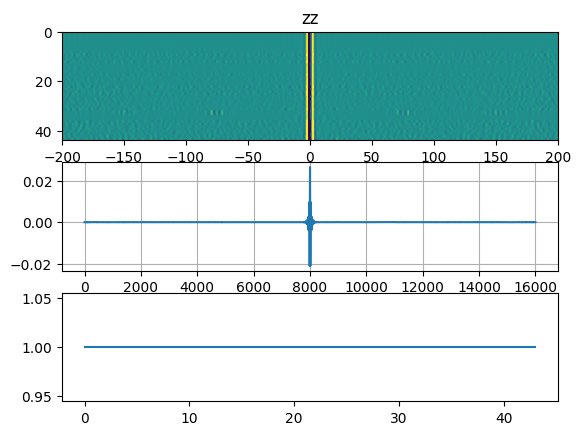

In [ ]:
enz_system = ["EE", "EN", "EZ", "NE", "NN", "NZ", "ZE", "ZN", "ZZ"]
nccomp=config.ncomp**2
print(nccomp)
freq1=freq[0]
freq2=freq[1]
dt=1/config.samp_freq

## Choose a component
comp = "zz"

# for icomp in range(1,nccomp):
#   comp = enz_system[icomp]
  # select only the data from the same cross-component cross correlations 
  # and that have sufficiently good windows
indx = np.where( (cc_comp.lower() == comp.lower()) & cc_ngood==1)[0]


# bandpass filter the data. 
tcur = np.zeros(shape=(len(indx),npts_segmt))
for i in range(len(indx)):
  tcur[i,:]=bandpass(cc_array[indx[i]], freq1, freq2, int(1 / dt), corners=4, zerophase=True)

fig,ax=plt.subplots(3,1)
ax[0].imshow(tcur,extent=[-config.maxlag,config.maxlag,iseg,0],aspect='auto',vmin=-0.0001,vmax=0.0001)
ax[0].set_title(comp)


# output stacked data
(
    cc_final,
    ngood_final,
    stamps_final,
    tref,
    allstacks2,
    allstacks3,
    nstacks,
) = noise_module.stacking(tcur, cc_time[indx], cc_ngood[indx], config)
ax[1].plot(tref);ax[1].grid(True)
ax[2].plot(ngood_final)

First, we will explore the stability of the correlations with respect to the reference.

We will first select a short window in the coda

In [ ]:
nwin = len(indx)  # number of windows to stack.
n2 = npts_segmt//2 # halfway in the cross correlation functions
t1 = 5. # starts at 5 seconds
t2 = 20. # ends at 15 seconds.
pwin_indx = n2+ np.arange(int(t1/dt),int(t2/dt)) # coda indexes in the positive lags
nwin_indx = n2 - np.arange(int(t1/dt),int(t2/dt))[::-1] # coda indexes in the negative lags
nwin_indx = nwin_indx[::-1] # flip time axes
print(pwin_indx)
print(nwin_indx)

[8200 8201 8202 8203 8204 8205 8206 8207 8208 8209 8210 8211 8212 8213
 8214 8215 8216 8217 8218 8219 8220 8221 8222 8223 8224 8225 8226 8227
 8228 8229 8230 8231 8232 8233 8234 8235 8236 8237 8238 8239 8240 8241
 8242 8243 8244 8245 8246 8247 8248 8249 8250 8251 8252 8253 8254 8255
 8256 8257 8258 8259 8260 8261 8262 8263 8264 8265 8266 8267 8268 8269
 8270 8271 8272 8273 8274 8275 8276 8277 8278 8279 8280 8281 8282 8283
 8284 8285 8286 8287 8288 8289 8290 8291 8292 8293 8294 8295 8296 8297
 8298 8299 8300 8301 8302 8303 8304 8305 8306 8307 8308 8309 8310 8311
 8312 8313 8314 8315 8316 8317 8318 8319 8320 8321 8322 8323 8324 8325
 8326 8327 8328 8329 8330 8331 8332 8333 8334 8335 8336 8337 8338 8339
 8340 8341 8342 8343 8344 8345 8346 8347 8348 8349 8350 8351 8352 8353
 8354 8355 8356 8357 8358 8359 8360 8361 8362 8363 8364 8365 8366 8367
 8368 8369 8370 8371 8372 8373 8374 8375 8376 8377 8378 8379 8380 8381
 8382 8383 8384 8385 8386 8387 8388 8389 8390 8391 8392 8393 8394 8395
 8396 

Calculate the cross correlation between the coda and the reference coda

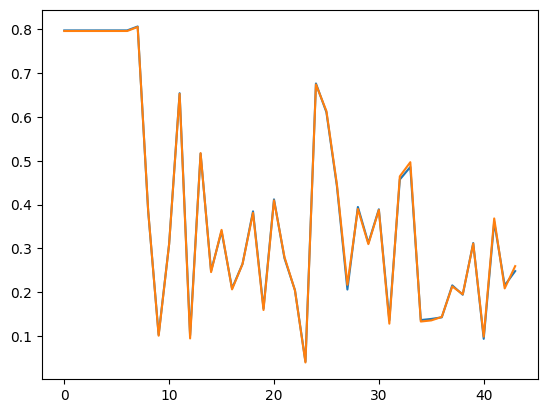

In [ ]:
pcor_cc = np.zeros(shape=(nwin), dtype=np.float32)
ncor_cc = np.zeros(shape=(nwin), dtype=np.float32)
for i in range(nwin):
  pcor_cc[i] = np.corrcoef(tref[pwin_indx], tcur[i, pwin_indx])[0, 1]
  ncor_cc[i] = np.corrcoef(tref[nwin_indx], tcur[i, nwin_indx])[0, 1]
plt.plot(pcor_cc)
plt.plot(ncor_cc)

The result is not great! Typically one tries to get a CC coefficient at least up to 0.8 before doing the dv/v measurements.

We will go ahead anyway and refine later.

Initialize all kinds of dv/v

In [ ]:

dvv_stretch = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_dtw = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_mwcs = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wcc = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wts = np.zeros(shape=(nwin, 4), dtype=np.float32)
dvv_wxs = np.zeros(shape=(nwin, 4), dtype=np.float32)



In [ ]:
para=dict()
para["freq"] = [freq1, freq2]
para["twin"] = [t1,t2]
para["dt"] = dt

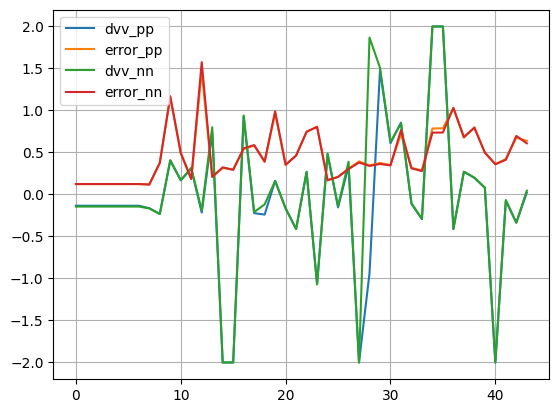

In [ ]:
for ii in range(nwin):
        # casual and acasual lags for both ref and cur waveforms
        pcur = tcur[ii, pwin_indx]
        ncur = tcur[ii, nwin_indx]
        pref = tref[pwin_indx]
        nref = tref[nwin_indx]

        # functions working in time domain
        if do_stretch:
            (
                dvv_stretch[ii, 0],
                dvv_stretch[ii, 1],
                cc,
                cdp,
            ) = noise_module.stretching(pref, pcur, epsilon, nbtrial, para)
            (
                dvv_stretch[ii, 2],
                dvv_stretch[ii, 3],
                cc,
                cdp,
            ) = noise_module.stretching(nref, ncur, epsilon, nbtrial, para)

plt.plot(dvv_stretch);plt.legend(('dvv_pp','error_pp','dvv_nn','error_nn'));plt.grid(True)

Now as an exercise, here is what we can try:

* save the data in a data frame with the correct timestamps. Save using PyArrow
* compare with other cross components
* add much more data, make substacks (maybe 12-hour stacks), to get a more stabl result.
* change  the frequency band
* compare MWCS and Stretching.
* try other stations for single-station correlations
* try inter-station cross correlation